In [1]:
from SimPEG import Mesh, Utils, Maps
import simpegSP as SP
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dx = 10.
hxind = [(dx, 3, -1.3), (dx, 20), (dx, 3, 1.3)]
hyind = [(dx, 3, -1.3), (dx, 20), (dx, 3, 1.3)]
hzind = [(dx, 3, -1.3), (dx, 15), (dx/2., 5)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], "CCN")
sigma = np.ones(mesh.nC)*1./100.
actind = mesh.gridCC[:,2] < -0.2
actMap = Maps.InjectActiveCells(mesh, actind, 0.)

In [3]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-80, mesh.vectorCCx<80.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-80, mesh.vectorCCy<80.)]
# xyzM = Utils.ndgrid(np.ones_like(x)*-80, np.ones_like(y)*-80, np.r_[0.])
xyzM = Utils.ndgrid(x+dx, y, np.r_[0.])
xyzN = Utils.ndgrid(x, y, np.r_[0.])

In [4]:
prb = SP.Problem_CC(mesh, sigma=sigma, qMap=Maps.IdentityMap(mesh), Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="CurrentSource")
survey = SP.Survey([src])
survey.pair(prb)

In [5]:
q = np.zeros(mesh.nC)
inda = Utils.closestPoints(mesh, np.r_[-80, 0., -40])
indb = Utils.closestPoints(mesh, np.r_[80, 0.,  -40])
indc = Utils.closestPoints(mesh, np.r_[0, -80., -40])
indd = Utils.closestPoints(mesh, np.r_[0, 80,  -40])

q[inda] = 1.
q[indb] = -1.
q[indc] = 1.
q[indd] = -1.
f = prb.fields(q)
# out = survey.dpred(q[actind], f=f)

In [6]:
# v = np.ones(mesh.nC)[actind]
# jvec = prb.Jvec(q[actind], q[actind])
# jtvec = prb.Jtvec(q[actind], np.ones_like(out))

In [7]:
# mesh.plotSlice(actMap*jtvec, normal="Z", ind=5)

(<matplotlib.collections.QuadMesh at 0x116473a50>,)

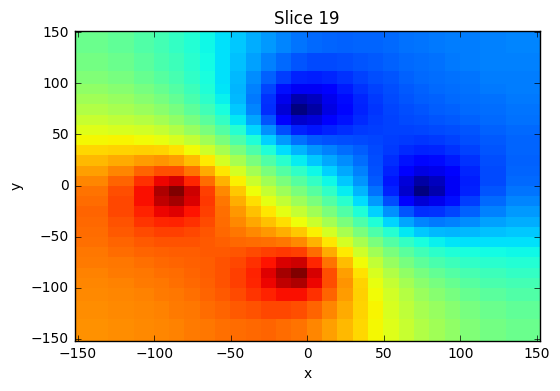

In [8]:
mesh.plotSlice(f[src, 'phi'], normal="Z", ind=19)

In [9]:
# Utils.plot2Ddata(xyzN[:,:2], dobs, scale="linear")
# # plt.plot(mesh.gridCC[inda,0], mesh.gridCC[inda,1], 'ko')
# # plt.plot(mesh.gridCC[indb,0], mesh.gridCC[indb,1], 'ro')

In [10]:
# hout = hist(np.log10(abs(dobs)),bins=100)

In [11]:
# print abs(dobs).min()
# print abs(dobs).max()*0.01

In [14]:
dobs = survey.dpred(q)
dobs+= np.random.randn(survey.nD)*abs(dobs).max() * 0.05

In [15]:
depthweight = 1./ ((abs(mesh.gridCC[:,2])+2.5)**3.)
depthweight /= depthweight.max()

In [16]:
# Generate Full sensitivity
I = np.diag(np.ones_like(dobs))
J = np.zeros((dobs.size, mesh.nC))
for i in range(dobs.size):
    J[i,:] = prb.Jtvec(sigma, I[:,i])
    JtJ = (J**2).sum(axis=0)
JtJ /= JtJ.max()
prb.G = J

In [17]:
# out = mesh.plotSlice(JtJ, normal="Y", ind=12)
# plt.colorbar(out[0])

In [18]:
# plt.plot(1./dmisfit.Wd.diagonal())

In [27]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.
survey.eps = abs(dobs).max() * 0.05
survey.dobs = dobs
 
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = mesh.nC)
reg = Regularization.Sparse(mesh, mapping=regmap)
reg.cell_weights = JtJ
reg.alpha_s = 1.
reg.alpha_x = 0.
reg.alpha_y = 0.
reg.alpha_z = 0.
opt = Optimization.ProjectedGNCG(maxIter=100, tolX=1e-20, tolF=1e-20)
opt.maxIterLS = 20
IRLS = Directives.Update_IRLS(norms=([0.,1.,1.,1.]),
                                     eps=None, f_min_change=1e-3,
                                     minGNiter=3)
senseweight = Directives.Update_Wj()
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 2.
updateprecond = Directives.Update_lin_PreCond()
# inv = Inversion.BaseInversion(invProb, directiveList=[betaest, updateprecond, IRLS])
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, beta, updateprecond, target])
# inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(mesh.nC)*0.
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.13e+07  1.86e+04  0.00e+00  1.86e+04    1.00e+06      0              
   1  8.13e+07  1.10e+03  1.50e-05  2.32e+03    8.96e+04      0              
   2  8.13e+07  8.48e+02  1.19e-05  1.82e+03    7.81e+04      0              
   3  1.63e+07  6.12e+02  1.17e-05  8.02e+02    7.01e+04      0              
   4  1.63e+07  1.58e+02  2.30e-05  5.33e+02    2.59e+04      0              
   5  1.63e+07  1.61e+02  2.00e-05  4.87e+02    1.58e+04      0              
   6  3.25e+06  1.30e+02  2.08e-05  1.98e+02    2.64e+04      0              
------------------------- STOP!

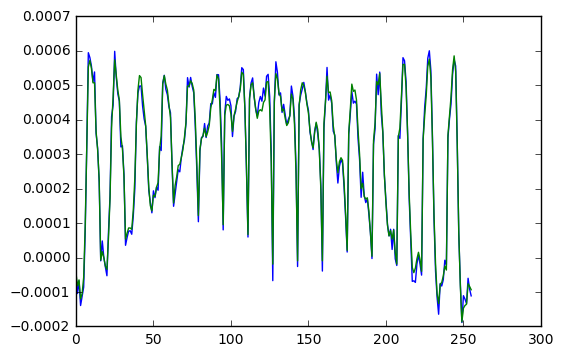

In [28]:
plt.plot(dobs)
plt.plot(invProb.dpred)

In [29]:
# out = mesh.plotSlice(reg.l2model, normal="Y", ind=12, clim=(-0.01, 0.01))
# plt.colorbar(out[0])

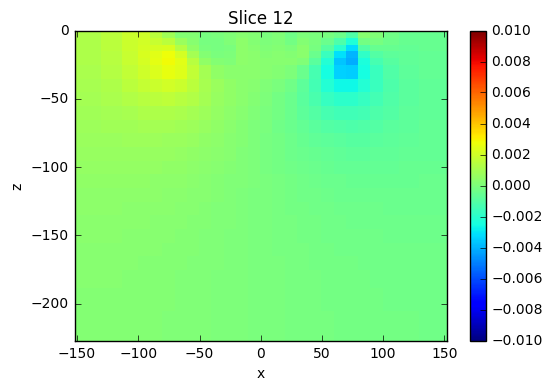

In [30]:
out = mesh.plotSlice(mopt, normal="Y", ind=12, clim=(-0.01, 0.01))
plt.colorbar(out[0])

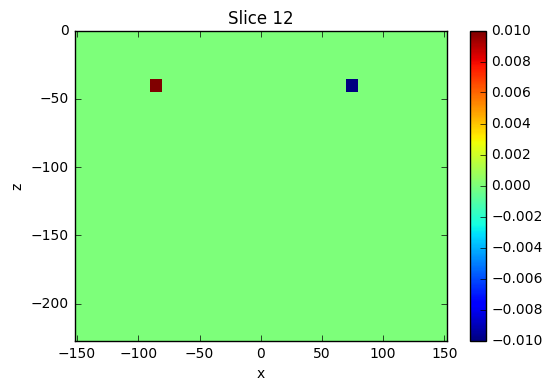

In [31]:
mesh.plotSlice(q, normal="Y", ind=12, clim=(-0.01, 0.01))
plt.colorbar(out[0])

In [32]:
# out = mesh.plotSlice(reg.l2model, normal="Z", ind=19, clim=(-0.01, 0.01))
# plt.colorbar(out[0])

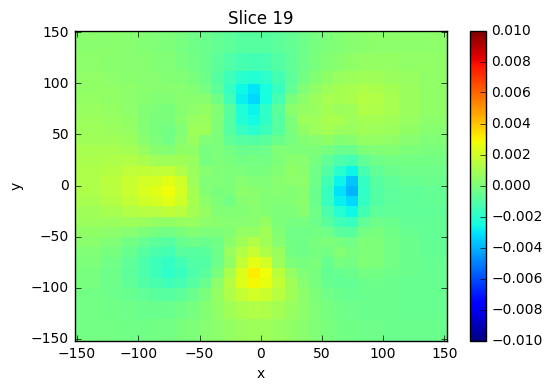

In [33]:
out = mesh.plotSlice(mopt, normal="Z", ind=19, clim=(-0.01, 0.01))
plt.colorbar(out[0])

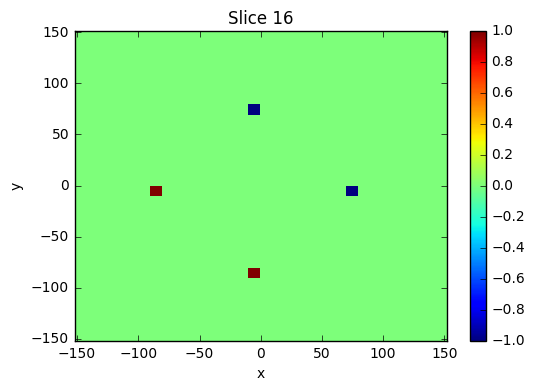

In [34]:
out = mesh.plotSlice(q, normal="Z", ind=16)
plt.colorbar(out[0])

In [36]:
# hout = hist(abs(reg.l2model), bins=200)
# plt.xlim(0, 0.008)
# plt.xscale("linear")

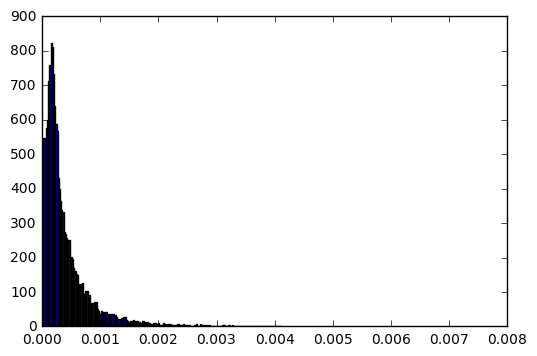

In [37]:
hout = hist(abs(mopt), bins=200)
plt.xlim(0, 0.008)
plt.xscale("linear")

(0, 0.0001)

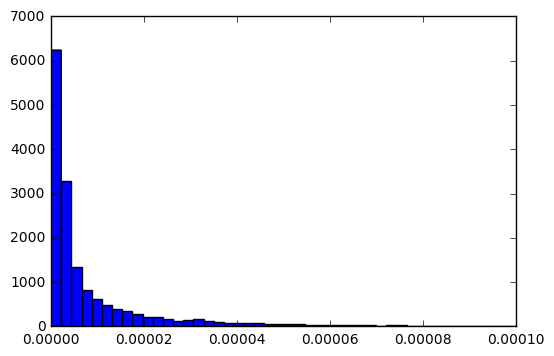

In [38]:
hout = hist(abs(mesh.cellGradx*mopt), bins=100)
plt.xscale("linear")
plt.xlim(0, 0.0001)

(<matplotlib.contour.QuadContourSet at 0x1237e5310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123535fd0>)

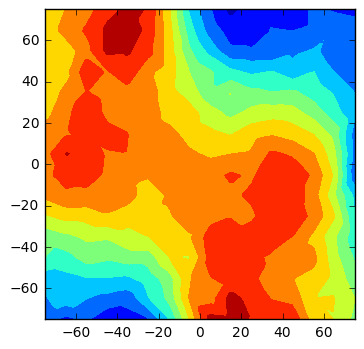

In [39]:
Utils.plot2Ddata(xyzN[:,:2], survey.dobs, scale="linear")

In [ ]:
Utils.plot2Ddata(xyzN[:,:2], invProb.dpred, scale="linear")